# Basic: Exploring QuickANFIS Options
This notebook shows how to use `QuickANFIS` effectively: selecting membership function types, choosing initialization (grid vs FCM), controlling the number of MFs, using `random_state` for determinism, and the alternative `for_function_approximation` helper.

## 1) Imports and setup
We'll import `QuickANFIS` and helpers. We'll also set a random seed for reproducibility.

In [19]:
import matplotlib.pyplot as plt
import numpy as np

from anfis_toolbox import QuickANFIS, quick_evaluate
from anfis_toolbox.optim import SGDTrainer

np.random.seed(42)  # For reproducibility

## 2) Create a small 2D regression dataset
We'll reuse this dataset to compare QuickANFIS options.

In [20]:
n = 300
X1 = np.random.uniform(-3, 3, size=n)
X2 = np.random.uniform(-2, 2, size=n)
X = np.column_stack([X1, X2])
y = np.sin(X1) + 0.3 * (X2 ** 2) + 0.1 * np.random.randn(n)
y = y.reshape(-1, 1)
X.shape, y.shape

((300, 2), (300, 1))

## 3) Quick start: defaults (gaussian MFs, grid init)
`QuickANFIS.for_regression` infers input ranges from data, distributes MFs on a grid, and uses Gaussian MFs by default. Training via `model.fit` uses the Hybrid trainer by default.

In [ ]:
model = QuickANFIS.for_regression(
    X,
    n_mfs=3,
    mf_type="gaussian",
    init="grid"
)
losses = model.fit(X, y, epochs=80, learning_rate=0.02, verbose=False)
metrics = quick_evaluate(model, X, y, print_results=True)

ANFIS Model Evaluation Results
Mean Squared Error (MSE):     0.009289
Root Mean Squared Error:      0.096377
Mean Absolute Error (MAE):    0.077391
R-squared (R²):               0.9861
Mean Abs. Percentage Error:   55.15%
Maximum Error:                0.296354
Standard Deviation of Error:  0.096377


## 4) Choosing membership function type (`mf_type`)
`mf_type` controls the shape family used for all inputs. Supported types include: `gaussian`, `triangular`, `trapezoidal`, `bell` (aka `gbell`), `sigmoidal` (aka `sigmoid`), `sshape` (aka `s`), `zshape` (aka `z`), and `pi` (aka `pimf`). We'll compare a few quickly.

In [29]:
mf_types = ["gaussian", "triangular", "bell", "sigmoidal"]
results_mf = {}
for mft in mf_types:
    m = QuickANFIS.for_regression(X, n_mfs=3, mf_type=mft, init="grid")
    ls = m.fit(X, y, epochs=60, learning_rate=0.02, verbose=False)
    results_mf[mft] = float(ls[-1])
    print(f"MF type: {mft}, final training loss: {ls[-1]:.4f}")

MF type: gaussian, final training loss: 0.0093
MF type: triangular, final training loss: 0.0119
MF type: triangular, final training loss: 0.0119
MF type: bell, final training loss: 0.0092
MF type: bell, final training loss: 0.0092
MF type: sigmoidal, final training loss: 0.0093
MF type: sigmoidal, final training loss: 0.0093


## 5) Initialization: `init="grid"` vs `init="fcm"`
- Grid: places MFs evenly across observed range (with small margins).
- FCM: uses Fuzzy C-Means on each input column to set centers and widths; supports all MF families used above.

In [ ]:
# Compare grid vs fcm for the same MF type
m_grid = QuickANFIS.for_regression(
    X,
    n_mfs=5,
    mf_type="gaussian",
    init="grid"
)
loss_grid = m_grid.fit(
    X,
    y,
    epochs=60,
    learning_rate=0.02,
    verbose=False
)[-1]

m_fcm = QuickANFIS.for_regression(
    X,
    n_mfs=5,
    mf_type="gaussian",
    init="fcm",
    random_state=42
)
loss_fcm = m_fcm.fit(
    X,
    y,
    epochs=60,
    learning_rate=0.02,
    verbose=False
)[-1]

print(f"Final training loss (grid init): {loss_grid:.4f}")
print(f"Final training loss (fcm init): {loss_fcm:.4f}")

Final training loss (grid init): 0.0082
Final training loss (fcm init): 0.0095


## 6) Number of MFs per input (`n_mfs`)
Increasing `n_mfs` adds rules and capacity. More isn't always better—watch for overfitting and compute cost.

In [31]:
nmfs_list = [2, 3, 5, 7]
results_nmfs = {}
for k in nmfs_list:
    m = QuickANFIS.for_regression(X, n_mfs=k, mf_type="gaussian", init="fcm", random_state=42)
    ls = m.fit(X, y, epochs=60, learning_rate=0.02, verbose=False)
    results_nmfs[k] = float(ls[-1])
    print(f"n_mfs: {k}, final training loss: {ls[-1]:.4f}")

n_mfs: 2, final training loss: 0.0481
n_mfs: 3, final training loss: 0.0192
n_mfs: 3, final training loss: 0.0192
n_mfs: 5, final training loss: 0.0095
n_mfs: 5, final training loss: 0.0095
n_mfs: 7, final training loss: 0.0054
n_mfs: 7, final training loss: 0.0054


## 7) Determinism and alternative trainer
- Use `random_state` with `init="fcm"` to get repeatable MF initialization.
- You can also pass a trainer explicitly to `fit`, e.g., `SGDTrainer` for pure backprop.

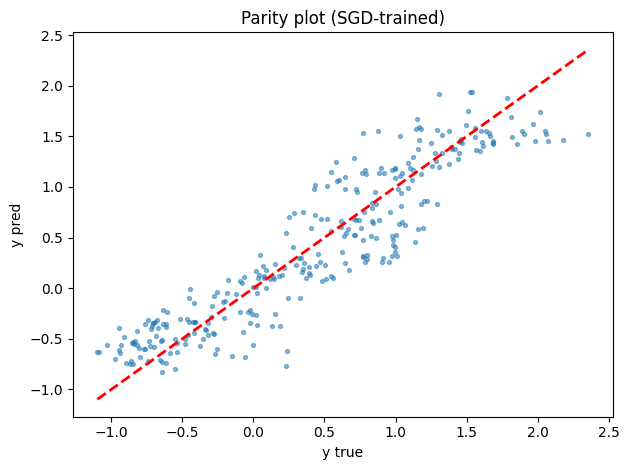

Final training loss (deterministic FCM init): 0.0124
Final training loss (SGD trainer): 0.1083


In [32]:
# Deterministic FCM init
m1 = QuickANFIS.for_regression(X, n_mfs=4, mf_type="bell", init="fcm", random_state=123)
loss1 = m1.fit(X, y, epochs=40, learning_rate=0.02, verbose=False)[-1]

m2 = QuickANFIS.for_regression(X, n_mfs=4, mf_type="bell", init="fcm", random_state=123)
loss2 = m2.fit(X, y, epochs=40, learning_rate=0.02, verbose=False)[-1]

# Explicit SGD trainer
sgd = SGDTrainer(learning_rate=0.02, epochs=40, batch_size=32, shuffle=True, verbose=False)
m_sgd = QuickANFIS.for_regression(X, n_mfs=4, mf_type="bell", init="fcm", random_state=123)
loss_sgd = m_sgd.fit(X, y, trainer=sgd)[-1]

# Simple parity plot for the last model
y_pred = m_sgd.predict(X)
plt.scatter(y, y_pred, s=8, alpha=0.5)
mn, mx = float(np.min(y)), float(np.max(y))
plt.plot([mn, mx], [mn, mx], "r--", lw=2)
plt.xlabel("y true")
plt.ylabel("y pred")
plt.title("Parity plot (SGD-trained)")
plt.tight_layout()
plt.show()

print(f"Final training loss (deterministic FCM init): {loss1:.4f}")
print(f"Final training loss (SGD trainer): {loss_sgd:.4f}")

## Tips & Next steps
- Start with `mf_type="gaussian"` and `init="fcm"` for robust baselines.
- Sweep `n_mfs` to balance fit quality and complexity; monitor R² or validation MSE.
- Try different MF families (`triangular`, `bell`, `pi`) when residuals show shape mismatches.
- For larger problems or streaming data, use `SGDTrainer` with mini-batches.
- For function approximation on known ranges, use `QuickANFIS.for_function_approximation([(min,max), ...])`.